In [47]:
import sys
import subprocess
import pkg_resources

required = {'numpy', 'pandas', 'tensorflow', 'keras'}
installed = {pkg.key for pkg in pkg_resources.working_set}
missing = required - installed

if missing:
    python = sys.executable
    subprocess.check_call([python, '-m', 'pip', 'install', *missing], stdout=subprocess.DEVNULL)

In [48]:
import tensorflow as tf
import numpy as np
import pandas as pd

### Import images

In [49]:
import os
import random

if not os.path.exists('keras_classification_sample'):
  !git clone https://github.com/pazamelin/keras_classification_sample.git

IMG_DIR = f'./keras_classification_sample/concrete-cracks/'
CONFIG = {
    'image_size': (227, 227),
    'batch_size': 25,
    'validation_split': 0.2,
    'seed': random.randint(0, 99999) 
}

train_ds = tf.keras.utils.image_dataset_from_directory(IMG_DIR, **CONFIG, subset="training")
validation_ds = tf.keras.utils.image_dataset_from_directory(IMG_DIR, **CONFIG, subset="validation")

class_names = train_ds.class_names
print(f'Class_names: {class_names}')

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 10000 files belonging to 2 classes.
Using 8000 files for training.
Found 10000 files belonging to 2 classes.
Using 2000 files for validation.
Class_names: ['negative', 'positive']


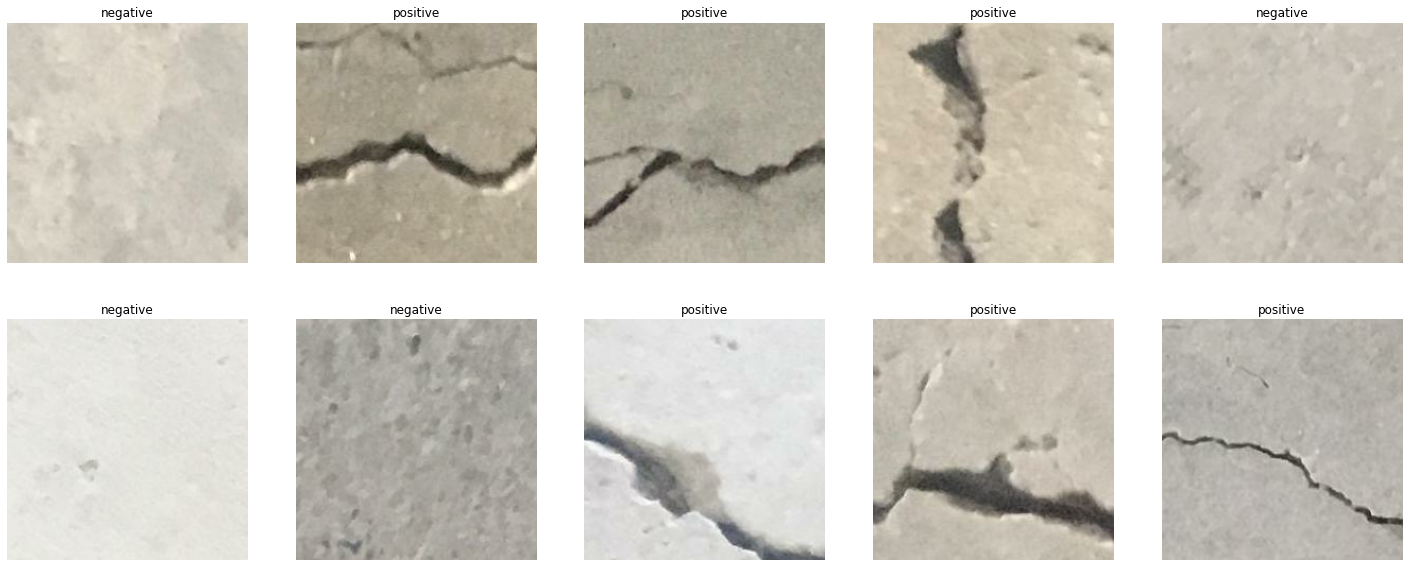

In [50]:
import matplotlib.pyplot as plt

plt.figure(figsize=(25, 10))
for images, labels in train_ds.take(1):
  for i in range(10):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Custom CNN

### Instantiate a model

In [51]:
from tensorflow.keras import models, layers

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',input_shape=(227, 227, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 225, 225, 32)      896       
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 110, 110, 64)      18496     
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 55, 55, 64)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 53, 53, 64)        36928     
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 26, 26, 64)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 24, 24, 128)      

### Configure the model for training

In [52]:
from tensorflow.keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-5),
              metrics=['acc']
)

### Fit the model

In [53]:
import time

# timing callback
class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)
        
time_callback = TimeHistory()

# fit model
history = model.fit(train_ds,
                    steps_per_epoch=16,
                    epochs=16,
                    validation_data=validation_ds,
                    validation_steps=50,
                    callbacks=[time_callback]
)

Epoch 1/16
16/16 [==============================] - 5s 208ms/step - loss: 0.8169 - acc: 0.6350 - val_loss: 0.4923 - val_acc: 0.9112
Epoch 2/16
16/16 [==============================] - 3s 189ms/step - loss: 0.4732 - acc: 0.8225 - val_loss: 0.4128 - val_acc: 0.9184
Epoch 3/16
16/16 [==============================] - 3s 191ms/step - loss: 0.3978 - acc: 0.8875 - val_loss: 0.3710 - val_acc: 0.9216
Epoch 4/16
16/16 [==============================] - 3s 187ms/step - loss: 0.3555 - acc: 0.9050 - val_loss: 0.3335 - val_acc: 0.8632
Epoch 5/16
16/16 [==============================] - 3s 195ms/step - loss: 0.3133 - acc: 0.9025 - val_loss: 0.2717 - val_acc: 0.9368
Epoch 6/16
16/16 [==============================] - 3s 189ms/step - loss: 0.2580 - acc: 0.9300 - val_loss: 0.2253 - val_acc: 0.9424
Epoch 7/16
16/16 [==============================] - 3s 195ms/step - loss: 0.2242 - acc: 0.9375 - val_loss: 0.2016 - val_acc: 0.9424
Epoch 8/16
16/16 [==============================] - 3s 196ms/step - loss: 0.

In [54]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=1, cols=2,
                    subplot_titles = ['Training and Validation Accuracy',
                                      'Training and Validation Loss'])

plots_positions = [(1, 1)] * 2 + [(1, 2)] * 2
metric_names = ['acc', 'val_acc', 'loss', 'val_loss']
epochs = list(range(1, history.params['epochs'] + 1))

for metric, (plot_row, plot_col) in zip(metric_names, plots_positions):
  fig.add_trace(
    go.Scatter(name=metric,
               x=epochs,
               y=history.history[metric]),
  row=plot_row, 
  col=plot_col
)   

fig.show()


## Training Times Comparison

In [55]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=1, cols=2,
                    subplot_titles = ['training time per epoch',
                                      'total time per epoch'])
timing_data = [time_callback.times]
timing_names = ['custom CNN']
epochs = list(range(1, history.params['epochs'] + 1))

for data, name in zip(timing_data, timing_names):
  # plot time per epoch
  fig.add_trace(
    go.Scatter(name=name,
               x=epochs,
               y=data),
    row = 1, col = 1   
  )    

# plot total time
total_times = [sum(data) for data in timing_data]
fig.add_trace(
  go.Bar(name='total time',
         x=timing_names,
         y=total_times),
    row = 1, col = 2   
  )
fig.show()
